In [486]:
import urllib2
from bs4 import BeautifulSoup
import re
import nytimesarticle as nyta
import urllib2
import requests
import csv
import time
import pandas as pd
import numpy as np
import nytimes_crawl_2 as nytc
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 2

# Misc

In [223]:
names = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fifteen']

## Analysis

### Scrape

In [8]:
reader1 = nytc.OpEdReader('one')
reader1.save_oped_articles_all_pages(begindate='20160101',enddate='20160331')

In [ ]:
reader2 = nytc.OpEdReader('two')
reader2.save_oped_articles_all_pages(begindate='20161001',enddate='20160107')

In [ ]:
reader3 = nytc.OpEdReader('three')
reader3.save_oped_articles_all_pages(begindate='20150701',enddate='20151011')

In [ ]:
reader4 = nytc.OpEdReader('four')
reader4.save_oped_articles_all_pages(begindate='20150401',enddate='20150717')

In [ ]:
reader5 = nytc.OpEdReader('five')
reader5.save_oped_articles_all_pages(begindate='20150101',enddate='20150421')

In [ ]:
reader6 = nytc.OpEdReader('six')
reader6.save_oped_articles_all_pages(begindate='20141001',enddate='20150125')

In [539]:
reader6.data.iloc[-1]

comment_count                                                   32
document_type                                              article
first_name                                                 vanessa
full_text        São Paulo, Brazil —  It was a typical election...
last_name                                                  barbara
like_count                                                     159
share_count                                                    109
url              http://www.nytimes.com/2014/10/31/opinion/vane...
Name: 949, dtype: object

### Load

In [436]:
reader1 = nytc.OpEdReader.init_from_file('one','one100.csv')
reader2 = nytc.OpEdReader.init_from_file('two','two100.csv')
reader3 = nytc.OpEdReader.init_from_file('three','three100.csv')
reader4 = nytc.OpEdReader.init_from_file('four','four100.csv')
reader5 = nytc.OpEdReader.init_from_file('five','five100.csv')
reader6 = nytc.OpEdReader.init_from_file('six','six100.csv')
reader7 = nytc.OpEdReader.init_from_file('seven','seven100.csv')

In [437]:
readers = [reader1,reader2,reader3,reader4,reader5,reader6]

### Eliminate 'Universal' Articles

In [438]:
def elim_universal_wrapper(reader):
    print(reader.data.shape)
    reader.elim_universal()
    print(reader.data.shape)

In [439]:
for reader in readers:
    elim_universal_wrapper(reader)

(947, 8)
(940, 8)
(952, 8)
(943, 8)
(959, 8)
(948, 8)
(945, 8)
(941, 8)
(944, 8)
(929, 8)
(955, 8)
(954, 8)


# Text Manipulation

In [14]:
import nltk

In [95]:
PUNCTUATION = """!@#$%^&*()_+=][{}'-";:/?\.,~`"""

def tidy_text(text):
    """ Does the following: 1. Tokenises words 2. Removes punctuation 3. Removes stop words 4. Puts words through the snowball stemmer"""

    stemmer = nltk.stem.snowball.EnglishStemmer()
    stopwords = set(nltk.corpus.stopwords.words('english'))

    outwords = []
    for word in text.split():
        word = word.strip(PUNCTUATION).lower()
        if word not in stopwords:
            if len(word) > 0:
                if not word[0].isdigit():
                    outwords.append(stemmer.stem(word))

    return outwords


## Foreign Language

In [440]:
def locate_foreign(tidiedtext,reader):
    for idx, text in enumerate(tidiedtext):
        if 'de' in text and 'la' in text:
            print('Match')
            print(idx)
            print(text[:20])
            print(reader.data['url'].iloc[idx])

In [441]:
def possible_matches(reader):
    text = reader.data['full_text']
    tidiedtext = [tidy_text(item.decode('utf-8')) for item in text]
    locate_foreign(tidiedtext,reader)

### Drop Foreign Articles

In [443]:
def drop_rows_all(reader,indices):
    print(reader.data.shape)
    reader.drop_rows(indices)
    print(reader.data.shape)
    csvfilename = '{0}_english{1}.csv'.format(reader.name,100)
    reader.save_to_csv(csvfilename)

### Source #1

In [444]:
drop_rows_all(reader,[105,355,508,534])
drop_rows_all(reader2,[55,396,459,504,516,542,549])
drop_rows_all(reader3,[])
drop_rows_all(reader4,[])
drop_rows_all(reader5,[])
drop_rows_all(reader6,[77,275,303,345,365,405,434,740,825,917])

(954, 8)
(950, 8)
(943, 8)
(936, 8)
(948, 8)
(948, 8)
(941, 8)
(941, 8)
(929, 8)
(929, 8)
(950, 8)
(940, 8)


## Save Results

In [445]:
for name, reader in zip(names,readers):
    filename = '{0}_english100.csv'.format(name)
    reader.save_to_csv(filename)

# Final Result

In [446]:
readers_english = []
for name in names[:6]:
    filename = '{0}_english100.csv'.format(name)
    readername = '{0}_english'.format(name)
    newreader = nytc.OpEdReader.init_from_file(readername,filename)
    readers_english.append(newreader)

## Tidy the Text, Join all Datasets

In [447]:
%%prun
dataall = pd.concat([reader.data for reader in readers_english])
text = dataall['full_text']
tidiedtext = [tidy_text(item.decode('utf-8')) for item in text]
tidiedtextjoined = [' '.join(text) for text in tidiedtext]

In [448]:
dataall = dataall.reset_index(drop=True)

# Fix Charles Blow!

In [371]:
import time

In [372]:
def get_author_name(url):
    soup = nytc.soupify_url(url)
    time.sleep(2)
    tag = soup.findAll('meta',{'name':'author'})[0]
    return tag.get('content')

In [373]:
def get_last_name(authorname):
    return authorname.split()[-1]

In [427]:
def fix_charles_blow(dataall):
    res = []
    for url, firstname, lastname in zip(dataall['url'],dataall['first_name'],dataall['last_name']):
        if firstname == 'charles' and pd.isnull(lastname):
            print(url)
            authorname = get_author_name(url)
            lastnamenew = get_last_name(authorname).lower()
        else:
            lastnamenew = lastname
        res.append(lastnamenew)
    dataall['last_name'] = res
    return dataall

In [456]:
dataall = fix_charles_blow(dataall)

## Save Results

### Scraped

In [512]:
dataall.to_csv('dataall.csv')

### Dates

In [466]:
datadate = pd.DataFrame(index=dataall.index,columns=['Dates','TidiedText'])

In [467]:
dates = [pd.to_datetime(nytc.parse_url_for_date(url)) for url in dataall['url']]

In [468]:
datadate['Dates'] = dates
datadate['TidiedText'] = tidiedtext

In [538]:
datadate.to_csv('datadate.csv')

# By Author

In [504]:
def df_author(dataall,firstname=None,lastname=None):
    def get_idx(field,val):
        if val is None:
            return pd.isnull(dataall[field])
        else:
            return dataall[field] == val
    df = dataall[get_idx('first_name',firstname) & get_idx('last_name',lastname)]
    return df

In [515]:
krugthulu = df_author(dataall,'paul','krugman')
brooks = df_author(dataall,'david','brooks')
collins = df_author(dataall,'gail','collins')
editorialboard = df_author(dataall,None,None)

## Distribution of 'Virality'

In [516]:
np.histogram(collins['share_count'],bins=100)

(array([ 3,  9, 12, 10,  5, 10,  6,  7,  2,  8,  2,  4,  3,  4,  4,  1,  1,
         0,  1,  0,  0,  0,  2,  0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]),
 array([   59.  ,   147.54,   236.08,   324.62,   413.16,   501.7 ,
          590.24,   678.78,   767.32,   855.86,   944.4 ,  1032.94,
         1121.48,  1210.02,  1298.56,  1387.1 ,  1475.64,  1564.18,
         1652.72,  1741.26,  1829.8 ,  1918.34,  2006.88,  2095.42,
         2183.96,  2272.5 ,  2361.04,  2449.58,  2538.12,  2626.66,
         2715.2 ,  2803.74,  2892.28,  2980.82,  3069.36,  3157.9 ,
         3246.44,  3334.98,  3423.52,  3512.06,  3600.6 ,  3689.14,
         3777.68,  3866.22,  3954.76,  4043.3 ,  4131.84,  4220.38,
      

# LDA

In [520]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [521]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [522]:
n_features = 1000
n_topics = 50
n_top_words = 20

In [523]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features)
t0 = time()
tf = tf_vectorizer.fit_transform(tidiedtextjoined)
print("done in %0.3fs." % (time() - t0))


Extracting tf features for LDA...
done in 2.639s.


In [524]:
print("Fitting LDA models with tf features and n_features=%d..."
      % (n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=20,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))


Fitting LDA models with tf features and n_features=1000...
done in 190.461s.


In [525]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
abort texa plan women search state anti health provid woman right care law restrict medic servic control access center doctor
Topic #1:
gun shoot violenc kill weapon peopl shot safeti murder carri victim death law mass nation public assault polic ban crime
Topic #2:
republican senat democrat hous committe presid congress obama year vote would leader repres white polit john nomin nation said major
Topic #3:
state syrian turkey popular shoot great muslim close group system iraq common unit legisl war entir syria question amend capit
Topic #4:
women men ms woman femal sexual work girl young sex one equal percent job said partner role man show like
Topic #5:
china unit state countri india chines trade govern agreement world would intern year econom foreign offici nation also north new
Topic #6:
citi new york hous state mr mayor build local neighborhood de year public street plan communiti resid need like would
Topic #7:
chang world climat global energi human

In [526]:
doc_topic_distrib = lda.transform(tf)

In [527]:
doc_topic_distrib /= doc_topic_distrib.sum(axis=1)[:, np.newaxis]

In [531]:
np.argmax(np.sum(doc_topic_distrib,axis=0))

31

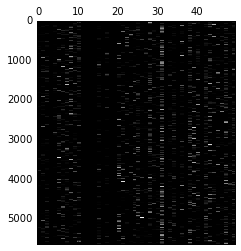

In [528]:
fig = plt.figure(1)
ax = fig.gca()
ax = ax.matshow(doc_topic_distrib, cmap=plt.cm.gray, aspect = '0.01')
plt.show()

In [533]:
def add_topic_weights(dataall,n_topics):
    columns = ['topic{0}'.format(topicnum) for topicnum in range(n_topics)]
    df = pd.DataFrame(index=dataall.index,columns=columns)
    for topicnum in range(n_topics):
        topicname = 'topic{0}'.format(topicnum)
        df[topicname] = doc_topic_distrib[:,topicnum]
    return df

In [534]:
topicweights = add_topic_weights(dataall,n_topics)

In [535]:
topicweights

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic40,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49
0,0.000058,0.000058,0.035605,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.157980,...,0.000058,0.000058,0.578121,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058
1,0.000041,0.000041,0.000041,0.000041,0.011712,0.000041,0.000041,0.000041,0.264534,0.030598,...,0.032336,0.000041,0.000041,0.000041,0.010920,0.000041,0.015506,0.021026,0.000041,0.000041
2,0.000042,0.000042,0.000042,0.000042,0.000042,0.020966,0.000042,0.000042,0.256074,0.033505,...,0.063319,0.000042,0.013002,0.016643,0.013962,0.000042,0.000042,0.041489,0.000042,0.360474
3,0.000067,0.229763,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.266562,0.000067,...,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067
4,0.348150,0.000063,0.000063,0.000063,0.035194,0.000063,0.000063,0.000063,0.128216,0.000063,...,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.155413,0.000063,0.000063
5,0.000098,0.000098,0.035548,0.000098,0.000098,0.000098,0.454117,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.182792,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
6,0.000088,0.000088,0.000088,0.000088,0.000088,0.000088,0.523095,0.000088,0.000088,0.000088,...,0.000088,0.000088,0.000088,0.000088,0.000088,0.007570,0.000088,0.000088,0.000088,0.000088
7,0.000118,0.013421,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,...,0.000118,0.000118,0.133351,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118
8,0.082433,0.007441,0.000029,0.000029,0.017437,0.000029,0.006386,0.000029,0.000029,0.000029,...,0.000029,0.000029,0.031611,0.000029,0.000029,0.010033,0.000029,0.000029,0.004745,0.000029
9,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.260772,...,0.000138,0.000138,0.000138,0.251229,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138


# Machine Learning

In [543]:
from sklearn import linear_model, neighbors

In [182]:
featurenames = ['topic{0}'.format(i) for i in range(n_topics)]
features = dataallnew[featurenames]
viralityname = 'comment_count'
virality = dataallnew[viralityname]

In [116]:
def split_data(data,frac=0.7):
    datanew = data.sample(frac=1)
    nrows = len(datanew)
    idx = int(nrows*frac)
    return {'train': data.iloc[:idx], 'test': data.iloc[idx:]}
    # use 70-30 split

In [117]:
def model_error(actual,predicted):
    nobs = actual.size
    return np.sqrt(1.0/(2.0*nobs)*np.sum((actual - predicted)**2))

In [138]:
def train_model(split_data,model,**kwargs):
    datatrain = split_data['train']
    datatest = split_data['test']
    model.fit(datatrain[featurenames],datatrain[viralityname],**kwargs)
    train_pred = model.predict(datatrain[featurenames])
    test_pred = model.predict(datatest[featurenames])
    train_error = model_error(train_pred,datatrain[viralityname])
    test_error = model_error(test_pred,datatest[viralityname])
    print('Training error: {0}'.format(train_error))
    print('Test error: {0}'.format(test_error))

In [183]:
datasplit = split_data(dataallnew)

## Scikit

### Linear Regression

In [184]:
model = linear_model.LinearRegression()

In [185]:
train_model(datasplit,model)

Training error: 4466.85599976
Test error: 4958.36058218


In [186]:
model = neighbors.KNeighborsRegressor(n_neighbors=10)

In [187]:
train_model(datasplit,model)

Training error: 4286.67999274
Test error: 5228.43172015


### K-Nearest Neighbors

In [122]:
np.mean(dataallnew[viralityname])

1827.3535460992907

In [189]:
for i in range(20,41):
    model = neighbors.KNeighborsRegressor(n_neighbors=i)
    train_model(datasplit,model)

Training error: 4428.34426296
Test error: 4962.46068522
Training error: 4425.95764532
Test error: 4961.31912638
Training error: 4434.9240012
Test error: 4965.88872017
Training error: 4436.04776169
Test error: 4965.02992353
Training error: 4429.60242854
Test error: 4956.48823479
Training error: 4436.26718057
Test error: 4953.81724536
Training error: 4440.30727807
Test error: 4950.2471327
Training error: 4435.36256929
Test error: 4947.27682918
Training error: 4440.78502872
Test error: 4947.78048079
Training error: 4445.08417232
Test error: 4947.92659495
Training error: 4446.44883483
Test error: 4943.89119088
Training error: 4450.49231511
Test error: 4944.65187809
Training error: 4452.4126632
Test error: 4944.51825879
Training error: 4455.92647462
Test error: 4938.58827005
Training error: 4457.9319017
Test error: 4938.69984464
Training error: 4457.66914247
Test error: 4943.08996305
Training error: 4459.72845127
Test error: 4939.15521043
Training error: 4463.11338804
Test error: 4934.58931